# Optimization II - Project 1 - The newsvendor problem

Team Members:

1. Aishwarya Sarkar (as99646)
2. Kshitij Mahajan (ksm3267)
3. Parthiv Borgohain (pb25347)
4. Shreyansh Agrawal (sa55742) 

In [ ]:
%pip install gurobipy
import numpy as np
import gurobipy as gp
import pandas as pd
from sklearn.linear_model import LinearRegression
import copy
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.8 MB/s eta 0:00:00


In [ ]:
df= pd.read_csv('price_demand_data.csv')
df.shape[0]

99

### 1. Fitting a linear regression model to price and demand dataset

In [ ]:
X = df.iloc[:,:-1]
Y = df['demand']
regression = LinearRegression().fit(X,Y)
print("R sq: ",regression.score(X, Y),"Coef: ",regression.coef_,"Intercept: ",regression.intercept_)


R sq:  0.6214724117783329 Coef:  [-1367.71252416] Intercept:  1924.7175435291088


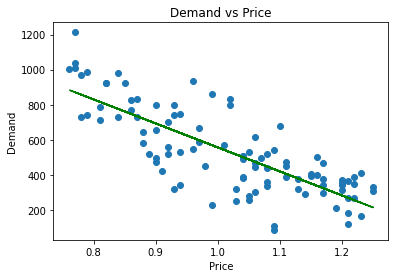

In [ ]:
# scatter plot predicted vs actuals

plt.scatter(X, Y)
plt.plot(X,X*regression.coef_[0] + regression.intercept_, color='green', linestyle='--')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand vs Price')
plt.show()

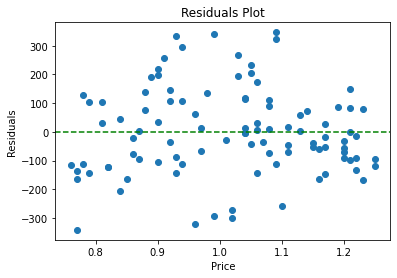

In [ ]:
y_pred = regression.predict(X)
residuals = y_pred-Y

# Residuals plot
plt.scatter(X, residuals)
plt.axhline(y=np.mean(residuals), color='green', linestyle = "--")
plt.xlabel('Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

### 2. Generation of demand data based on residuals and p=1, c= 0.5, g =0.75, t = 0.15

In [ ]:
p = 1
c = 0.5
g = 0.75
t = 0.15

In [ ]:
df['residual'] =df['demand']-(df['price']*regression.coef_+regression.intercept_)
demand_data = pd.DataFrame(copy.deepcopy(df['residual']))
demand_data['price'] = 1
demand_data['demand'] = demand_data['price']*regression.coef_+regression.intercept_+demand_data['residual']
demand_data

,residual,price,demand
0,-205.619393,1,351.385626
1,22.515227,1,579.520247
2,-84.785389,1,472.219630
3,-108.067771,1,448.937249
4,116.743975,1,673.748994
...,...,...,...
94,-58.202391,1,498.802628
95,112.098225,1,669.103245
96,-115.296518,1,441.708501
97,301.349231,1,858.354250


### 3. Optimal quantity deduction
The equations will be:

pD - qc - g(d-q) if d>q

and 

pd - qc -t(q-d) if q>d

In [ ]:
new_days = demand_data.shape[0]

obj = np.zeros(new_days+1)
obj[1:] = 1.0/new_days
lb = np.zeros(new_days+1)
lb[1:] = -np.inf

A = np.zeros((2*new_days, len(obj)))
rhs = np.zeros(2*new_days)
direction = np.array(['<']*2*new_days)

for i in range(new_days):
    A[i, 0] = c-g
    A[i, i+1] = 1
    rhs[i] = demand_data['demand'][i]*(p-g)
    
    A[new_days+i,0] = c+t
    A[new_days+i, i+1] = 1
    rhs[new_days+i] = demand_data['demand'][i]*(p+t)

var_type = np.array(['I']+['C']*new_days)


In [ ]:
Model = gp.Model()
Model_x = Model.addMVar(len(obj),lb=lb,vtype=var_type) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Model_con = Model.addMConstr(A, Model_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Model.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Model.setParam('TimeLimit', 200)
Model.Params.OutputFlag = 0 # tell gurobi to shut up!!
Model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-13
Set parameter TimeLimit to value 200


In [ ]:
Model.objVal

231.48305473619084

In [ ]:
Model_x.x[0]

472.0

In [ ]:
print("The optimal quantity to order is"+" "+str(Model_x.x[0]))

The optimal quantity to order is 472.0


In [ ]:
print("Expected profit per day is "+str(Model.objVal))

Expected profit per day is 231.48305473619084


### 4. With price impacting demand, solving QCP

In [ ]:
obj2 = np.array([0,0]+[1/new_days]*new_days)

Q = np.zeros((new_days+2, new_days+2))
Q[0,0] = regression.coef_

A2 = np.zeros((2*new_days,len(obj2)))
rhs2 = np.zeros(2*new_days)
direction2 = np.array(['<']*(2*new_days))
lb2 = np.zeros(len(obj2))
lb2[2:] = -np.inf

for i in range(new_days):
    A2[i, 0] = g*regression.coef_-demand_data['residual'][i]-regression.intercept_
    A2[i, i+2] = 1
    A2[i, 1] = c-g
    rhs2[i] = -g*(regression.intercept_+demand_data['residual'][i])
    
    A2[new_days+i, 0] = -(regression.intercept_+t*regression.coef_+demand_data['residual'][i])
    A2[new_days+i, i+2] = 1
    A2[new_days+i, 1] = c+t
    
    rhs2[new_days+i] = t*(regression.intercept_+demand_data['residual'][i])
    

In [ ]:
Model2 = gp.Model()
Model2_x = Model2.addMVar(len(obj2), lb=lb2) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Model2_con = Model2.addMConstr(A2, Model2_x, direction2, rhs2) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Model2.setMObjective(Q,obj2,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Model2.setParam('TimeLimit', 60)
Model2.Params.OutputFlag = 0 # tell gurobi to shut up!!
Model2.optimize()

Set parameter TimeLimit to value 60


In [ ]:
Model2.objVal

234.42493487832962

In [ ]:
Model2_x.x[:10]

array([9.53626497e-01, 5.35291001e+02, 1.35366008e+03, 1.50854611e+03,
       1.48669687e+03, 1.46132064e+03, 1.52773358e+03, 1.46595297e+03,
       1.44053493e+03, 1.48845923e+03])

In [ ]:
print('The optimal quantity to print initially is '+ str(Model2_x.x[1]))

The optimal quantity to print initially is 535.2910012788652


In [ ]:
print("The optimal price of a print is "+str(Model2_x.x[0]))

The optimal price of a print is 0.9536264966232653


In [ ]:
print("Expected profit per day is "+str(Model2.objVal))

Expected profit per day is 234.42493487832962


### 6. Optimal solution for a bootstrap of the dataset

In [ ]:
np.random.seed(100)

bootstrap = np.arange(df.shape[0])
picked_row = np.random.choice(bootstrap, size=df.shape[0], replace=True)

df2 = df.iloc[picked_row,:-1]
df2

Y2 = df2['demand']
X2 = df2.iloc[:,:-1]
regression2 = LinearRegression().fit(X2,Y2)
print(regression2.score(X2, Y2),regression2.coef_,regression2.intercept_)

df2['residual'] =df2['demand']-((df2['price']*regression2.coef_)+regression2.intercept_)
demand_data2 = pd.DataFrame(copy.deepcopy(df2['residual']))
demand_data2['price'] = 1
demand_data2['demand'] = demand_data2['price']*regression2.coef_+regression2.intercept_+demand_data2['residual']

0.6109436802020731 [-1357.43063047] 1894.3024692160361


In [ ]:
obj3 = np.array([0,0]+[1/new_days]*new_days)
Q3 = np.zeros((new_days+2, new_days+2))
Q3[0,0] = regression2.coef_

A3 = np.zeros((2*new_days,len(obj3)))
rhs3 = np.zeros(2*new_days)
dir3 = np.array(['<']*(2*new_days))
lb3 = np.zeros(len(obj3))
lb3[2:] = -np.inf

for i in range(new_days):
    A3[i, 0] = g*regression2.coef_-demand_data2['residual'].iloc[i]-regression2.intercept_
    A3[i, i+2] = 1
    A3[i, 1] = c-g
    
    rhs3[i] = -g*(regression2.intercept_+demand_data2['residual'].iloc[i])
    
    A3[new_days+i, 0] = -(regression2.intercept_+t*regression2.coef_+demand_data2['residual'].iloc[i])
    A3[new_days+i, i+2] = 1
    A3[new_days+i, 1] = c+t
    
    rhs3[new_days+i] = t*(regression2.intercept_+demand_data2['residual'].iloc[i])


# Solve the optimization problem
Model3 = gp.Model()
Model3_x = Model3.addMVar(len(obj3), lb=lb3) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
Model3_con = Model3.addMConstr(A3, Model3_x, dir3, rhs3) # NAME THE CONSTRAINTS!!! so we can get information about them later!
Model3.setMObjective(Q3,obj3,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
Model3.setParam('TimeLimit', 60)
Model3.Params.OutputFlag = 0 # tell gurobi to shut up!!
Model3.optimize()

Model3.objVal

Set parameter TimeLimit to value 60


228.00714157692278

In [ ]:
Model3_x.x[:2]

array([  0.94775296, 521.32728775])

In [ ]:
print("Following are the required values for bootstraped model:\n"+
        "Expected Profits: "+str(Model3.objVal)+"\n"+
        "Optimal Price: "+str(Model3_x.x[0])+"\n"+
        "Optimal Quantity: "+str(Model3_x.x[1])+"\n"
)

Following are the required values for bootstraped model:
Expected Profits: 228.00714157692278
Optimal Price: 0.9477529557276547
Optimal Quantity: 521.3272877537446



### 7. Multiple bootstrap runs to check optimal price/quantity and expected profits

In [ ]:
optimal_price = []
optimal_quantity = []
expect_profit = []

for seed in range(1, 1000):
    np.random.seed(seed)

    bootstrap = np.arange(df.shape[0])
    picked_row = np.random.choice(bootstrap, size=df.shape[0], replace=True)

    df2 = df.iloc[picked_row,:-1]
    df2

    Y2 = df2['demand']
    X2 = df2.iloc[:,:-1]
    regression2 = LinearRegression().fit(X2,Y2)
    print(regression2.score(X2, Y2),regression2.coef_,regression2.intercept_)

    df2['residual'] =df2['demand']-((df2['price']*regression2.coef_)+regression2.intercept_)
    demand_df2 = pd.DataFrame(copy.deepcopy(df2['residual']))
    demand_df2['price'] = 1
    demand_df2['demand'] = demand_df2['price']*regression2.coef_+regression2.intercept_+demand_df2['residual']


    obj3 = np.array([0,0]+[1/new_days]*new_days)
    Q3 = np.zeros((new_days+2, new_days+2))
    Q3[0,0] = regression2.coef_

    A3 = np.zeros((2*new_days,len(obj3)))
    rhs3 = np.zeros(2*new_days)
    dir3 = np.array(['<']*(2*new_days))
    lb3 = np.zeros(len(obj3))
    lb3[2:] = -np.inf

    for i in range(new_days):
        A3[i, 0] = g*regression2.coef_-demand_df2['residual'].iloc[i]-regression2.intercept_
        A3[i, i+2] = 1
        A3[i, 1] = c-g
    
        rhs3[i] = -g*(regression2.intercept_+demand_df2['residual'].iloc[i])
        A3[new_days+i, 0] = -(regression2.intercept_+t*regression2.coef_+demand_df2['residual'].iloc[i])
        A3[new_days+i, i+2] = 1
        A3[new_days+i, 1] = c+t
        rhs3[new_days+i] = t*(regression2.intercept_+demand_df2['residual'].iloc[i])

    # Solve the optimization problem
    Model3 = gp.Model()
    Model3_x = Model3.addMVar(len(obj3), lb=lb3) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    Model3_con = Model3.addMConstr(A3, Model3_x, dir3, rhs3) # NAME THE CONSTRAINTS!!! so we can get information about them later!
    Model3.setMObjective(Q3,obj3,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
    Model3.setParam('TimeLimit', 60)
    Model3.Params.OutputFlag = 0 # tell gurobi to shut up!!
    Model3.optimize()

    best_price = Model3_x.x[0]
    optimal_price.append(best_price)
    
    best_q = Model3_x.x[1]
    optimal_quantity.append(best_q)
    
    expect_profit.append(Model3.objVal)

0.6429408137682144 [-1412.27152166] 1962.125703213048
Set parameter TimeLimit to value 60
0.6648420694874043 [-1394.8928906] 1947.9186339118892
Set parameter TimeLimit to value 60
0.6373751314518052 [-1532.68363369] 2078.2155947267643
Set parameter TimeLimit to value 60
0.6467795474197173 [-1460.37495042] 2045.075290085729
Set parameter TimeLimit to value 60
0.5711816340896012 [-1323.02011817] 1845.8233787048785
Set parameter TimeLimit to value 60
0.7122466365271785 [-1479.60991623] 2043.4529027881413
Set parameter TimeLimit to value 60
0.6144973511430301 [-1321.65936441] 1882.0836676697656
Set parameter TimeLimit to value 60
0.6649822765947258 [-1401.58135664] 1978.3191717423929
Set parameter TimeLimit to value 60
0.5371038980049405 [-1377.08692653] 1933.5223980055816
Set parameter TimeLimit to value 60
0.4889936324140729 [-1234.38019918] 1781.9872114821328
Set parameter TimeLimit to value 60
0.6800867180285899 [-1382.16854964] 1955.3913791544323
Set parameter TimeLimit to value 60
0.

0.5668697129376985 [-1428.87041382] 2009.1619096519362
Set parameter TimeLimit to value 60
0.6942020539407632 [-1288.73637192] 1857.5118211415374
Set parameter TimeLimit to value 60
0.49417362204960213 [-1211.53368756] 1757.276786095344
Set parameter TimeLimit to value 60
0.684536227881628 [-1384.41379806] 1954.5568980828039
Set parameter TimeLimit to value 60
0.6772769456315899 [-1475.46636211] 2034.343179994129
Set parameter TimeLimit to value 60
0.6619673454694444 [-1398.4054008] 1961.2290343321042
Set parameter TimeLimit to value 60
0.5780086785027846 [-1200.02215599] 1743.3663982455157
Set parameter TimeLimit to value 60
0.4818347726756669 [-1174.0685153] 1739.1420664682714
Set parameter TimeLimit to value 60
0.6109436802020731 [-1357.43063047] 1894.3024692160361
Set parameter TimeLimit to value 60
0.5894704679893218 [-1325.39438572] 1886.681644692224
Set parameter TimeLimit to value 60
0.712031238597201 [-1389.36927187] 1948.0115131448915
Set parameter TimeLimit to value 60
0.671

Set parameter TimeLimit to value 60
0.6110021823661591 [-1327.60767112] 1876.8950961564185
Set parameter TimeLimit to value 60
0.6015074263202348 [-1451.08850594] 1994.084796435864
Set parameter TimeLimit to value 60
0.619799573571383 [-1303.89011666] 1866.0161129628295
Set parameter TimeLimit to value 60
0.6111494609334152 [-1451.15860351] 1987.393446858338
Set parameter TimeLimit to value 60
0.6374993177103239 [-1388.93379378] 1928.035048815118
Set parameter TimeLimit to value 60
0.600661161968693 [-1455.13958401] 2017.1322132312555
Set parameter TimeLimit to value 60
0.6172845383984205 [-1232.91907406] 1781.3673369850687
Set parameter TimeLimit to value 60
0.7177025195864727 [-1469.44460503] 2047.378387163274
Set parameter TimeLimit to value 60
0.6142660182434718 [-1345.53208131] 1887.398101449771
Set parameter TimeLimit to value 60
0.5838397629792937 [-1399.8379922] 1967.6416546152386
Set parameter TimeLimit to value 60
0.6289826551450591 [-1384.70071914] 1922.4288883155195
Set par

Set parameter TimeLimit to value 60
0.647108106772506 [-1335.29793059] 1901.3295290440074
Set parameter TimeLimit to value 60
0.5774603918538741 [-1480.38158392] 2016.5438620246516
Set parameter TimeLimit to value 60
0.4845138903445262 [-1093.86165972] 1639.6282676794433
Set parameter TimeLimit to value 60
0.7110764640791927 [-1464.45294054] 2035.6831692831051
Set parameter TimeLimit to value 60
0.6515328047374482 [-1374.97037097] 1932.1211678437107
Set parameter TimeLimit to value 60
0.6451967772449411 [-1239.46039124] 1789.9023829194414
Set parameter TimeLimit to value 60
0.6848969296257349 [-1378.64859684] 1933.997245383077
Set parameter TimeLimit to value 60
0.6491686739460669 [-1433.49323062] 1978.9884309927047
Set parameter TimeLimit to value 60
0.5602687628829579 [-1288.2173238] 1844.6160855913922
Set parameter TimeLimit to value 60
0.6611755842171909 [-1447.92842046] 2020.9327862298378
Set parameter TimeLimit to value 60
0.6392025194404383 [-1335.78273198] 1883.1552426583225
Se

0.4969962242101361 [-1153.09047194] 1693.8962333135341
Set parameter TimeLimit to value 60
0.5875713244353182 [-1290.51115974] 1835.0026491611966
Set parameter TimeLimit to value 60
0.6341749123688873 [-1408.72446154] 1962.9655973642148
Set parameter TimeLimit to value 60
0.6470834914370942 [-1409.38373272] 1967.6746667655862
Set parameter TimeLimit to value 60
0.6314877507582544 [-1498.38741723] 2071.596608480035
Set parameter TimeLimit to value 60
0.6526002418947683 [-1480.86346859] 2049.627267459065
Set parameter TimeLimit to value 60
0.6298567515083113 [-1410.78628576] 1991.2741278341045
Set parameter TimeLimit to value 60
0.6259121378048488 [-1297.67101537] 1852.0305785537132
Set parameter TimeLimit to value 60
0.610672187633452 [-1378.3746334] 1957.7319809204432
Set parameter TimeLimit to value 60
0.6319509751060535 [-1351.50530467] 1899.1628154566833
Set parameter TimeLimit to value 60
0.6329666248383572 [-1354.69470662] 1915.0185762138935
Set parameter TimeLimit to value 60
0.6

Set parameter TimeLimit to value 60
0.6390628230564022 [-1292.01596092] 1844.1882626980391
Set parameter TimeLimit to value 60
0.6636278270123458 [-1472.30859322] 2051.141563533268
Set parameter TimeLimit to value 60
0.6170280318601603 [-1292.16322505] 1843.4019862997375
Set parameter TimeLimit to value 60
0.535967714864488 [-1332.02681692] 1890.1142513122056
Set parameter TimeLimit to value 60
0.5721121701740934 [-1412.06761765] 1988.5020765590693
Set parameter TimeLimit to value 60
0.6201589167589971 [-1409.59119128] 1972.006333216196
Set parameter TimeLimit to value 60
0.6444956076025052 [-1415.30853652] 1961.1323802002457
Set parameter TimeLimit to value 60
0.5660416571420435 [-1326.24113475] 1903.3215130023646
Set parameter TimeLimit to value 60
0.6421696749722794 [-1327.6168328] 1901.6938367268945
Set parameter TimeLimit to value 60
0.5912935958745424 [-1219.52086363] 1785.14948364676
Set parameter TimeLimit to value 60
0.703548868945967 [-1379.54984741] 1938.3801052304755
Set pa

Set parameter TimeLimit to value 60
0.648009462173214 [-1235.56839185] 1800.1298950487662
Set parameter TimeLimit to value 60
0.5702538613985664 [-1300.75308352] 1844.4082961031186
Set parameter TimeLimit to value 60
0.6354543848578081 [-1341.02740229] 1892.0734863723571
Set parameter TimeLimit to value 60
0.6279554403220956 [-1376.12958971] 1930.034323437963
Set parameter TimeLimit to value 60
0.6455326008142241 [-1308.29483391] 1856.2490739096568
Set parameter TimeLimit to value 60
0.6215672023623195 [-1371.92298452] 1924.53296690292
Set parameter TimeLimit to value 60
0.5735700408713327 [-1296.54448716] 1850.1870487550175
Set parameter TimeLimit to value 60
0.5930501653693947 [-1391.77708411] 1932.976344837121
Set parameter TimeLimit to value 60
0.6532503902668476 [-1446.87088367] 1998.667183321028
Set parameter TimeLimit to value 60
0.5450539747434178 [-1375.76445509] 1928.6203757627177
Set parameter TimeLimit to value 60
0.5346087166639495 [-1330.70262299] 1868.1647129736582
Set p

Set parameter TimeLimit to value 60
0.6395311736468801 [-1282.14865378] 1839.7557766589907
Set parameter TimeLimit to value 60
0.7021788917899212 [-1557.36422517] 2124.2491189494226
Set parameter TimeLimit to value 60
0.5842214547732265 [-1230.22049462] 1800.7392228211643
Set parameter TimeLimit to value 60
0.58734420053368 [-1380.77577204] 1935.4712947768012
Set parameter TimeLimit to value 60
0.6773888377134369 [-1405.88692409] 1995.4141332242289
Set parameter TimeLimit to value 60
0.6833318381391345 [-1518.99158645] 2080.6382377003647
Set parameter TimeLimit to value 60
0.4915781835366366 [-1251.97672416] 1804.4602449765193
Set parameter TimeLimit to value 60
0.6401857414637214 [-1328.84789644] 1882.9382740021579
Set parameter TimeLimit to value 60
0.6727397952165037 [-1357.1245535] 1909.6219415776027
Set parameter TimeLimit to value 60
0.661745836667909 [-1543.97843414] 2108.680747853338
Set parameter TimeLimit to value 60
0.7009006572706373 [-1370.08800984] 1935.3297540561289
Set 

Set parameter TimeLimit to value 60
0.6334868660370313 [-1281.11953245] 1829.652499407875
Set parameter TimeLimit to value 60
0.5386242097166176 [-1299.82255289] 1849.4244192882861
Set parameter TimeLimit to value 60
0.6118148737778168 [-1379.23702837] 1917.1979509186503
Set parameter TimeLimit to value 60
0.5254870275298126 [-1248.18223284] 1802.7035434520985
Set parameter TimeLimit to value 60
0.6915390423176656 [-1525.13871797] 2103.444231494107
Set parameter TimeLimit to value 60
0.5299687072443091 [-1354.81329441] 1883.693054670986
Set parameter TimeLimit to value 60
0.5791394779970827 [-1346.88899752] 1903.2656963384907
Set parameter TimeLimit to value 60
0.6365405477817881 [-1353.79750609] 1908.4697352079088
Set parameter TimeLimit to value 60
0.6014860794694666 [-1370.83440858] 1939.0393826171507
Set parameter TimeLimit to value 60
0.6110436975632201 [-1309.05255962] 1838.0764814302033
Set parameter TimeLimit to value 60
0.7385456398204135 [-1468.62860717] 2053.8181839840386
Se

Set parameter TimeLimit to value 60
0.599878074227125 [-1386.99908203] 1938.3432085162697
Set parameter TimeLimit to value 60
0.6166237871054407 [-1291.31083774] 1858.7338917796499
Set parameter TimeLimit to value 60
0.587104048933728 [-1436.51093191] 1973.613955245988
Set parameter TimeLimit to value 60
0.6841171157554504 [-1476.23557968] 2031.9887372415556
Set parameter TimeLimit to value 60
0.6607827035454916 [-1481.24320906] 2037.8700446953844
Set parameter TimeLimit to value 60
0.5807170173892762 [-1388.96769902] 1933.5769914083157
Set parameter TimeLimit to value 60
0.6252567245462726 [-1440.95588752] 2039.4512605675636
Set parameter TimeLimit to value 60
0.7120024223063055 [-1375.18574977] 1956.6682120391433
Set parameter TimeLimit to value 60
0.6633655337233476 [-1393.38319799] 1937.8431891215905
Set parameter TimeLimit to value 60
0.6622932616789423 [-1330.37230012] 1899.526507121634
Set parameter TimeLimit to value 60
0.5524017243929047 [-1284.43145505] 1818.5358571845245
Set

0.6484591847753289 [-1311.03850079] 1860.4242248035346
Set parameter TimeLimit to value 60
0.5784949005162634 [-1502.03101072] 2051.961739715066
Set parameter TimeLimit to value 60
0.6377364580250434 [-1511.47943038] 2089.9861550632904
Set parameter TimeLimit to value 60
0.6352207226066668 [-1399.28480109] 1941.5826170335172
Set parameter TimeLimit to value 60
0.5917715296019741 [-1392.5989327] 1938.210330135404
Set parameter TimeLimit to value 60
0.7287431376558506 [-1335.82769344] 1909.5105540563948
Set parameter TimeLimit to value 60
0.6197993956526926 [-1434.16201061] 1981.4880136447953
Set parameter TimeLimit to value 60
0.6887194786607006 [-1312.42674069] 1880.4788802349458
Set parameter TimeLimit to value 60
0.696480233107044 [-1453.81978032] 2012.2390117616078
Set parameter TimeLimit to value 60
0.6471336761094985 [-1379.53301311] 1928.791699857199
Set parameter TimeLimit to value 60
0.5962529211056926 [-1421.67482197] 1953.761352309109
Set parameter TimeLimit to value 60
0.623

Text(27.0, 0.5, 'Optimal Quantity')

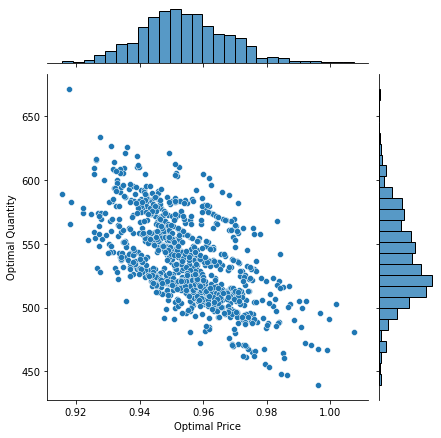

In [ ]:
scatter=sns.jointplot(x=optimal_price, y=optimal_quantity)
scatter.ax_joint.set_xlabel('Optimal Price')
scatter.ax_joint.set_ylabel('Optimal Quantity')

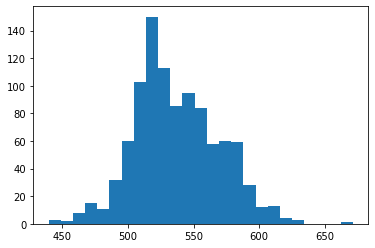

In [ ]:
plt.hist(optimal_quantity, bins=25)
plt.show()

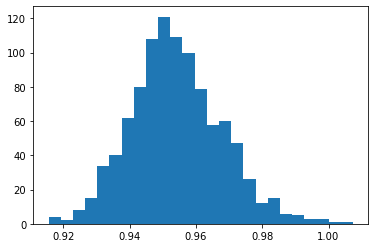

In [ ]:
plt.hist(optimal_price, bins=25)
plt.show()

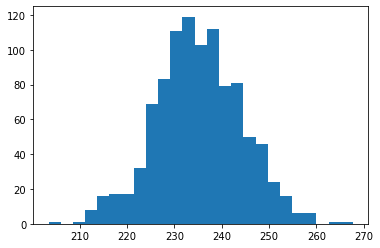

In [ ]:
plt.hist(expect_profit, bins=25)
plt.show()

In [ ]:
print("Mean of Expected Profits is $",np.array(expect_profit).mean(),"+-",1.96*np.array(expect_profit).std(),\
      "(95% Conf. Interval)")

Mean of Expected Profits is $ 235.19674344656693 +- 17.78632036131377 (95% Conf. Interval)


In [ ]:
print("Mean of Optimal Price is $",np.array(optimal_price).mean(),"+-",1.96*np.array(optimal_price).std(),\
      "(95% Conf. Interval)")

Mean of Optimal Price is $ 0.9541491192796726 +- 0.02692448583489639 (95% Conf. Interval)


In [ ]:
print("Mean of Optimal Quantity is $",np.array(optimal_quantity).mean(),"+-",1.96*np.array(optimal_quantity).std(),\
      "(95% Conf. Interval)")

Mean of Optimal Quantity is $ 536.7849412337071 +- 63.26145463862553 (95% Conf. Interval)
